In [1]:
from glob import glob
import pandas as pd
import numpy as np
import dask.dataframe as dd
import proplot as plot
from satpy import Scene

## Read Data

In [2]:
merge_dir = '../data/GOES-16/merged/'
df = dd.read_csv(merge_dir+'merged_2020*.csv', skiprows=4).compute().dropna()

# select positive updraft
df = df[df['w']>0]
# positive updraft keeps more than 40 min for each case
map_cell = df['cell'].map(df['cell'].value_counts())
# df = df[(map_cell >= 9)&(map_cell <= 15)]
# df = df[map_cell == 8]
df = df[map_cell >= 8]

df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M:%S')
df = df.set_index('time')

## Pick Cases

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# df_complete = df.groupby('cell').filter(lambda x: (x['HT'].max() >= 15) & (x['HT'].min() <= 7))
df_complete = df.groupby('cell').filter(lambda x: (x['HT'].max() <= 10) & (x['HT'].min() <= 7))

In [5]:
# # for cell in df['cell'].value_counts()[-15:].index:
# for cell in df_complete['cell'].value_counts().index:
#     f, axs = plot.subplots(ncols=3, share=0)
#     df[df['cell']==cell].plot.scatter(ax=axs[0], x='lon', y='lat', c='C13', cmap='viridis')
#     df[df['cell']==cell].plot.scatter(ax=axs[1], x='w', y='HT')
#     df[df['cell']==cell].plot.scatter(ax=axs[2], x='flash_extent_density', y='HT')
#     axs.format(title=str(cell))
# #     fig.savefig(f'../figures/cases/{cell}.jpg')
# #     print(cell)
# #     break

Issues:
- Because we only pick the w>0 data, some tracks are not continious.
- tobac may track different convections as one

These won't affect our analysis, but for the case plot, it's better to show the continous and obvious figure to the readers.

## Function of plotting

In [6]:
def plot_case(axs, cell):
    '''plot scatter distribution of CTH ~ w/FED/MFA/TOE'''
    df_cell = df[df['cell']==cell]
    axs[0].plot(df_cell['w'], df_cell['HT'], linewidth=1, c='gray6')
    axs[0].scatter(df_cell['w'], df_cell['HT'],
                   c=df_cell['time_cell'],
                   cmap='viridis')
    axs[0].format(xlabel='w (m/s)',
                  xlim=(0, df_cell['w'].max()+0.5))

    axs[1].plot(df_cell['flash_extent_density'], df_cell['HT'], linewidth=1, c='gray6')
    axs[1].scatter(df_cell['flash_extent_density'], df_cell['HT'],
                   c=df_cell['time_cell'],
                   cmap='viridis', colorbar='r',
                   colorbar_kw={'label': 'Minutes since track', 'labelsize': 12})
    axs[1].format(xlabel='FED (flashes/5min)', xlim=(0, df_cell['flash_extent_density'].max()+0.5))

    axs[2].plot(df_cell['minimum_flash_area'], df_cell['HT'], linewidth=1, c='gray6')
    axs[2].scatter(df_cell['minimum_flash_area'], df_cell['HT'], c=df_cell['time_cell'],
                   cmap='viridis')
    axs[2].format(xlabel=r'MFA (km$^2$, 20 km $\times$ 20 km)', xlim=(df_cell['minimum_flash_area'].min()-10, df_cell['minimum_flash_area'].max()+50))

    axs[3].plot(df_cell['total_energy'], df_cell['HT'], linewidth=1, c='gray6')
    axs[3].scatter(df_cell['total_energy'], df_cell['HT'], c=df_cell['time_cell'],
                   cmap='viridis', colorbar='r', colorbar_kw={'label': 'Minutes since track', 'labelsize': 12})
    axs[3].format(xlabel='TOE (fJ)', xlim=(0, df_cell['total_energy'].max()+200))

    for ax in axs:
        ax.xaxis.label.set_size(12)
        ax.yaxis.label.set_size(12)

    # date = df.index[0].strftime('%Y-%m-%d')
    lon = '%.2f' % abs(df_cell['lon'][0])
    lat = '%.2f' % df_cell['lat'][0]
    # title = date + ' ' + lon + f'$^\circ$W, ' + lat_1 + f'$^\circ$N'
    title = lon + f'$^\circ$W, ' + lat + f'$^\circ$N'

    axs.format(grid=False, ylabel='CTH (km)', suptitle=title)

## Case 1: Weak convection (cell: 1168000)

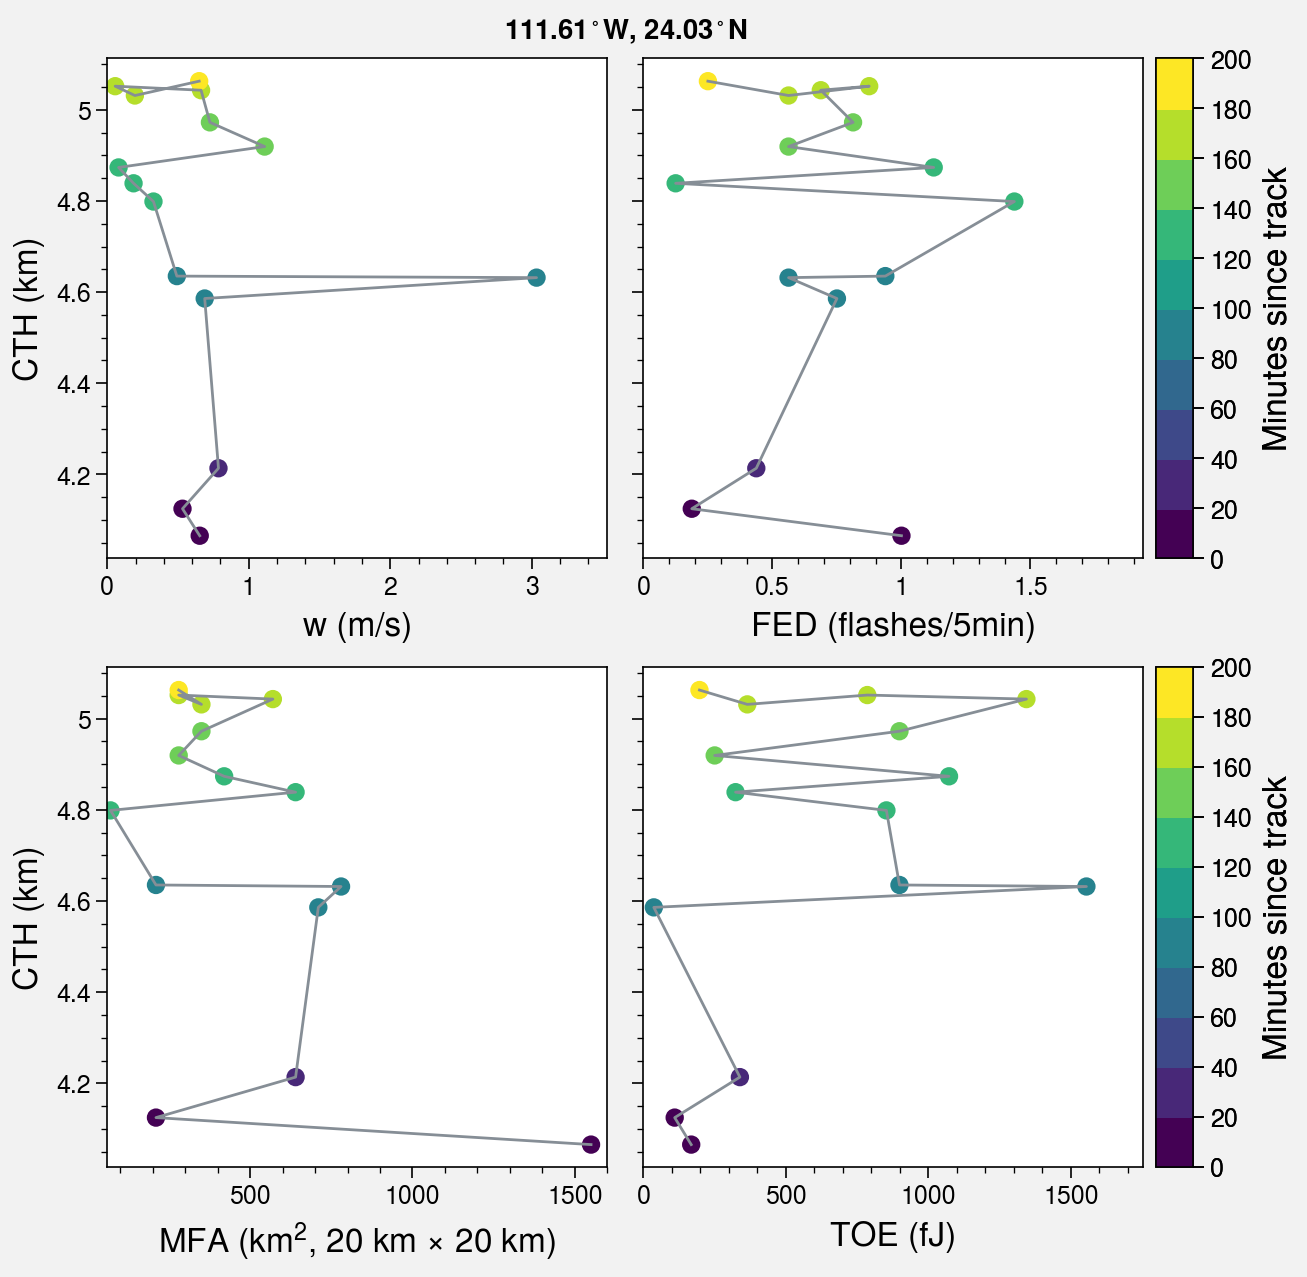

In [7]:
fig, axs = plot.subplots(nrows=2, ncols=2, sharex=0, spany=0)
plot_case(axs, cell=1168000)

## Case 2: Deep convection (cell: 2146106)

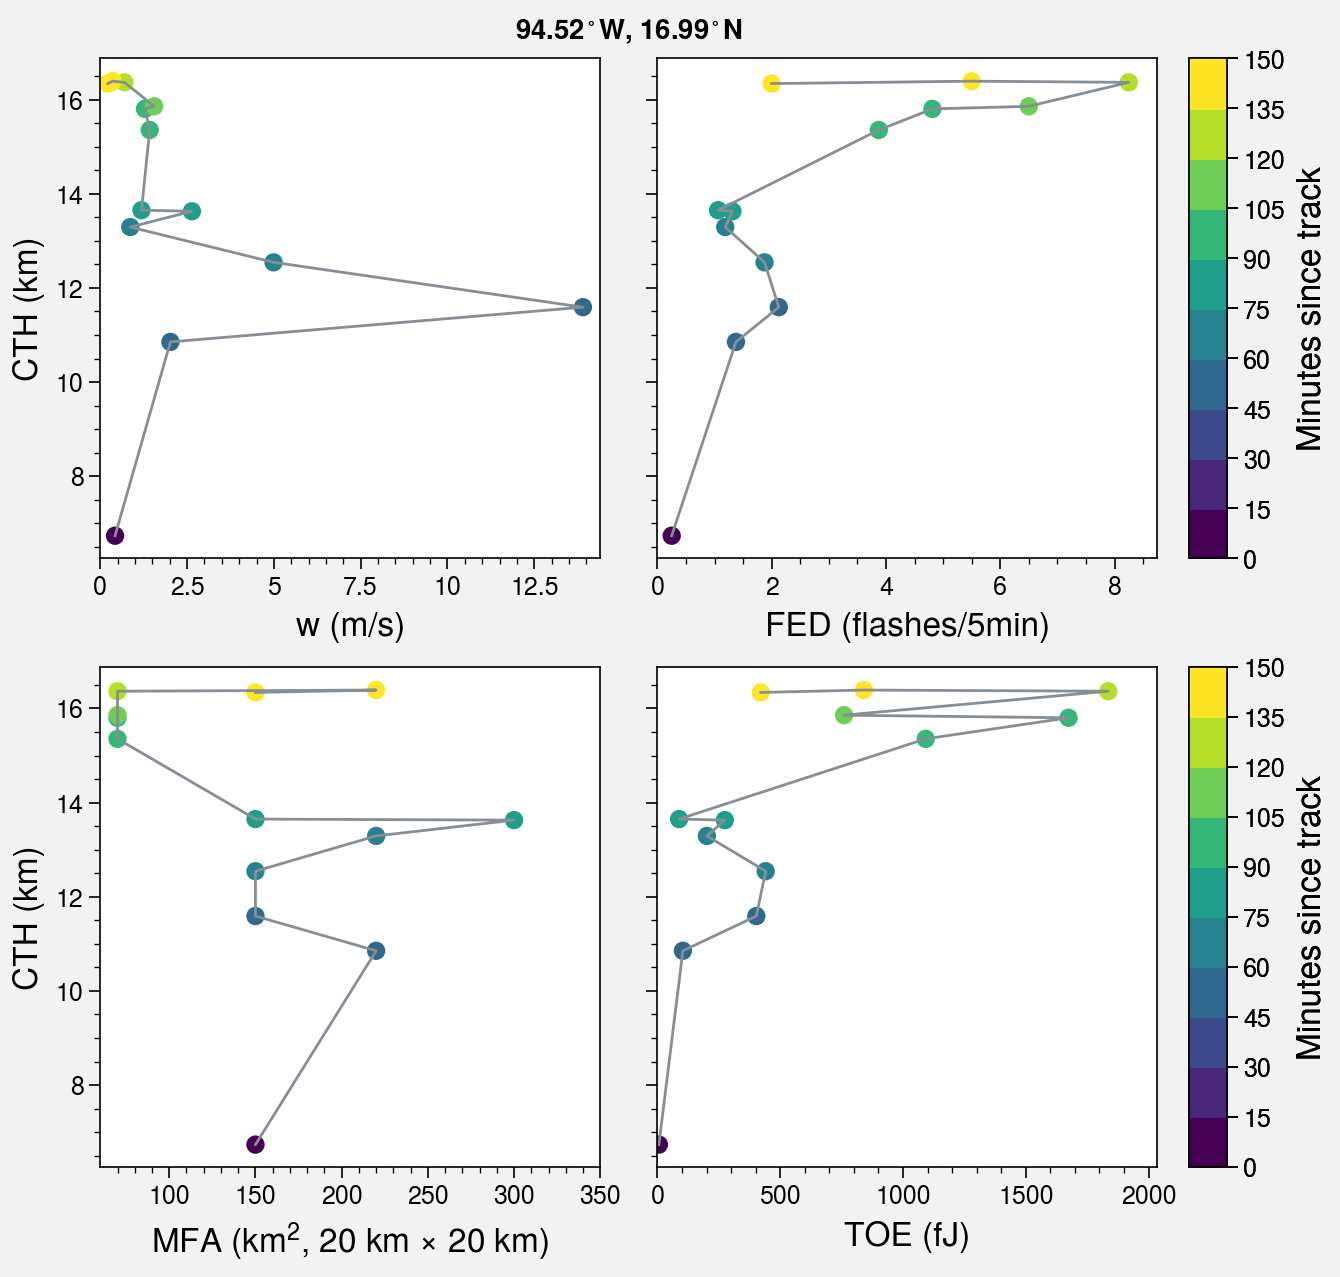

In [8]:
fig, axs = plot.subplots(nrows=2, ncols=2, sharex=0, spany=0)
plot_case(axs, cell=2146106)

## Final figures

It's better to show the ABI TBB at the developing stage of these two cases.

Readers can better understand what happened.

In [9]:
abi_dir = '../data/GOES-16/ABI_L1/'
abi_name = 'OR_ABI-L1b-RadC-M6C13_G16_s'
abi_channel = 'C13'
abi_reader = 'abi_l1b'

In [10]:
def plot_tbb(ax, cell, index=-3):
    '''plot the ABI TBB near the end of track time'''
    df_cell = df[df['cell']==cell]

    f_abi = glob(abi_dir+abi_name+df_cell.index[index].strftime('%Y%j%H%M')+'*')
    lon = '%.2f' % abs(df['lon'][index])
    lat = '%.2f' % df['lat'][index]
    time_cell = df_cell['time_cell'][index]

    scn = Scene(f_abi, reader=abi_reader)
    scn.load(['C13'])

    xmin, ymin = scn['C13'].area.get_projection_coordinates_from_lonlat(df_cell['lon'][-1] - 1, df_cell['lat'][-1] - 1)
    xmax, ymax = scn['C13'].area.get_projection_coordinates_from_lonlat(df_cell['lon'][-1] + 1, df_cell['lat'][-1] + 1)
    xcenter = (xmin+xmax)/2
    ycenter = (ymin+ymax)/2
    print(xmin, xmax, ymax, ymin)
    
    subset_field = scn['C13'].sel(x=slice(xmin, xmax),
                                  y=slice(ymax, ymin))

    # subset_field.plot(cbar_kwargs=dict(label='TBB (K)'))#vmin=190, vmax=310, levels=256, cbar_kwargs=dict(label='TBB (K)'))
    levels = np.arange(180, 340, 20)
    subset_field.plot(ax=ax, vmin=180, vmax=320, levels=256, cbar_kwargs=dict(label='TBB (K)', ticks=levels))
    ax.scatter(xcenter, ycenter, c='w')

    suptitle = scn['C13'].attrs['start_time'].strftime('%Y-%m-%d %H:%M (UTC)')
    title = str(time_cell) +' minutes since track \n(' + lon + f'$^\circ$W, ' + lat + f'$^\circ$N)'

    ax.format(suptitle=suptitle, title=title, suptitlesize=15, titlesize=12,
              xticks=[], yticks=[], xlabel='', ylabel='',)

    return 'case_'+suptitle[:10]

### Case 1

-3401965.646356074 -3199980.3052570466 2577026.4970240504 2382014.4711157805


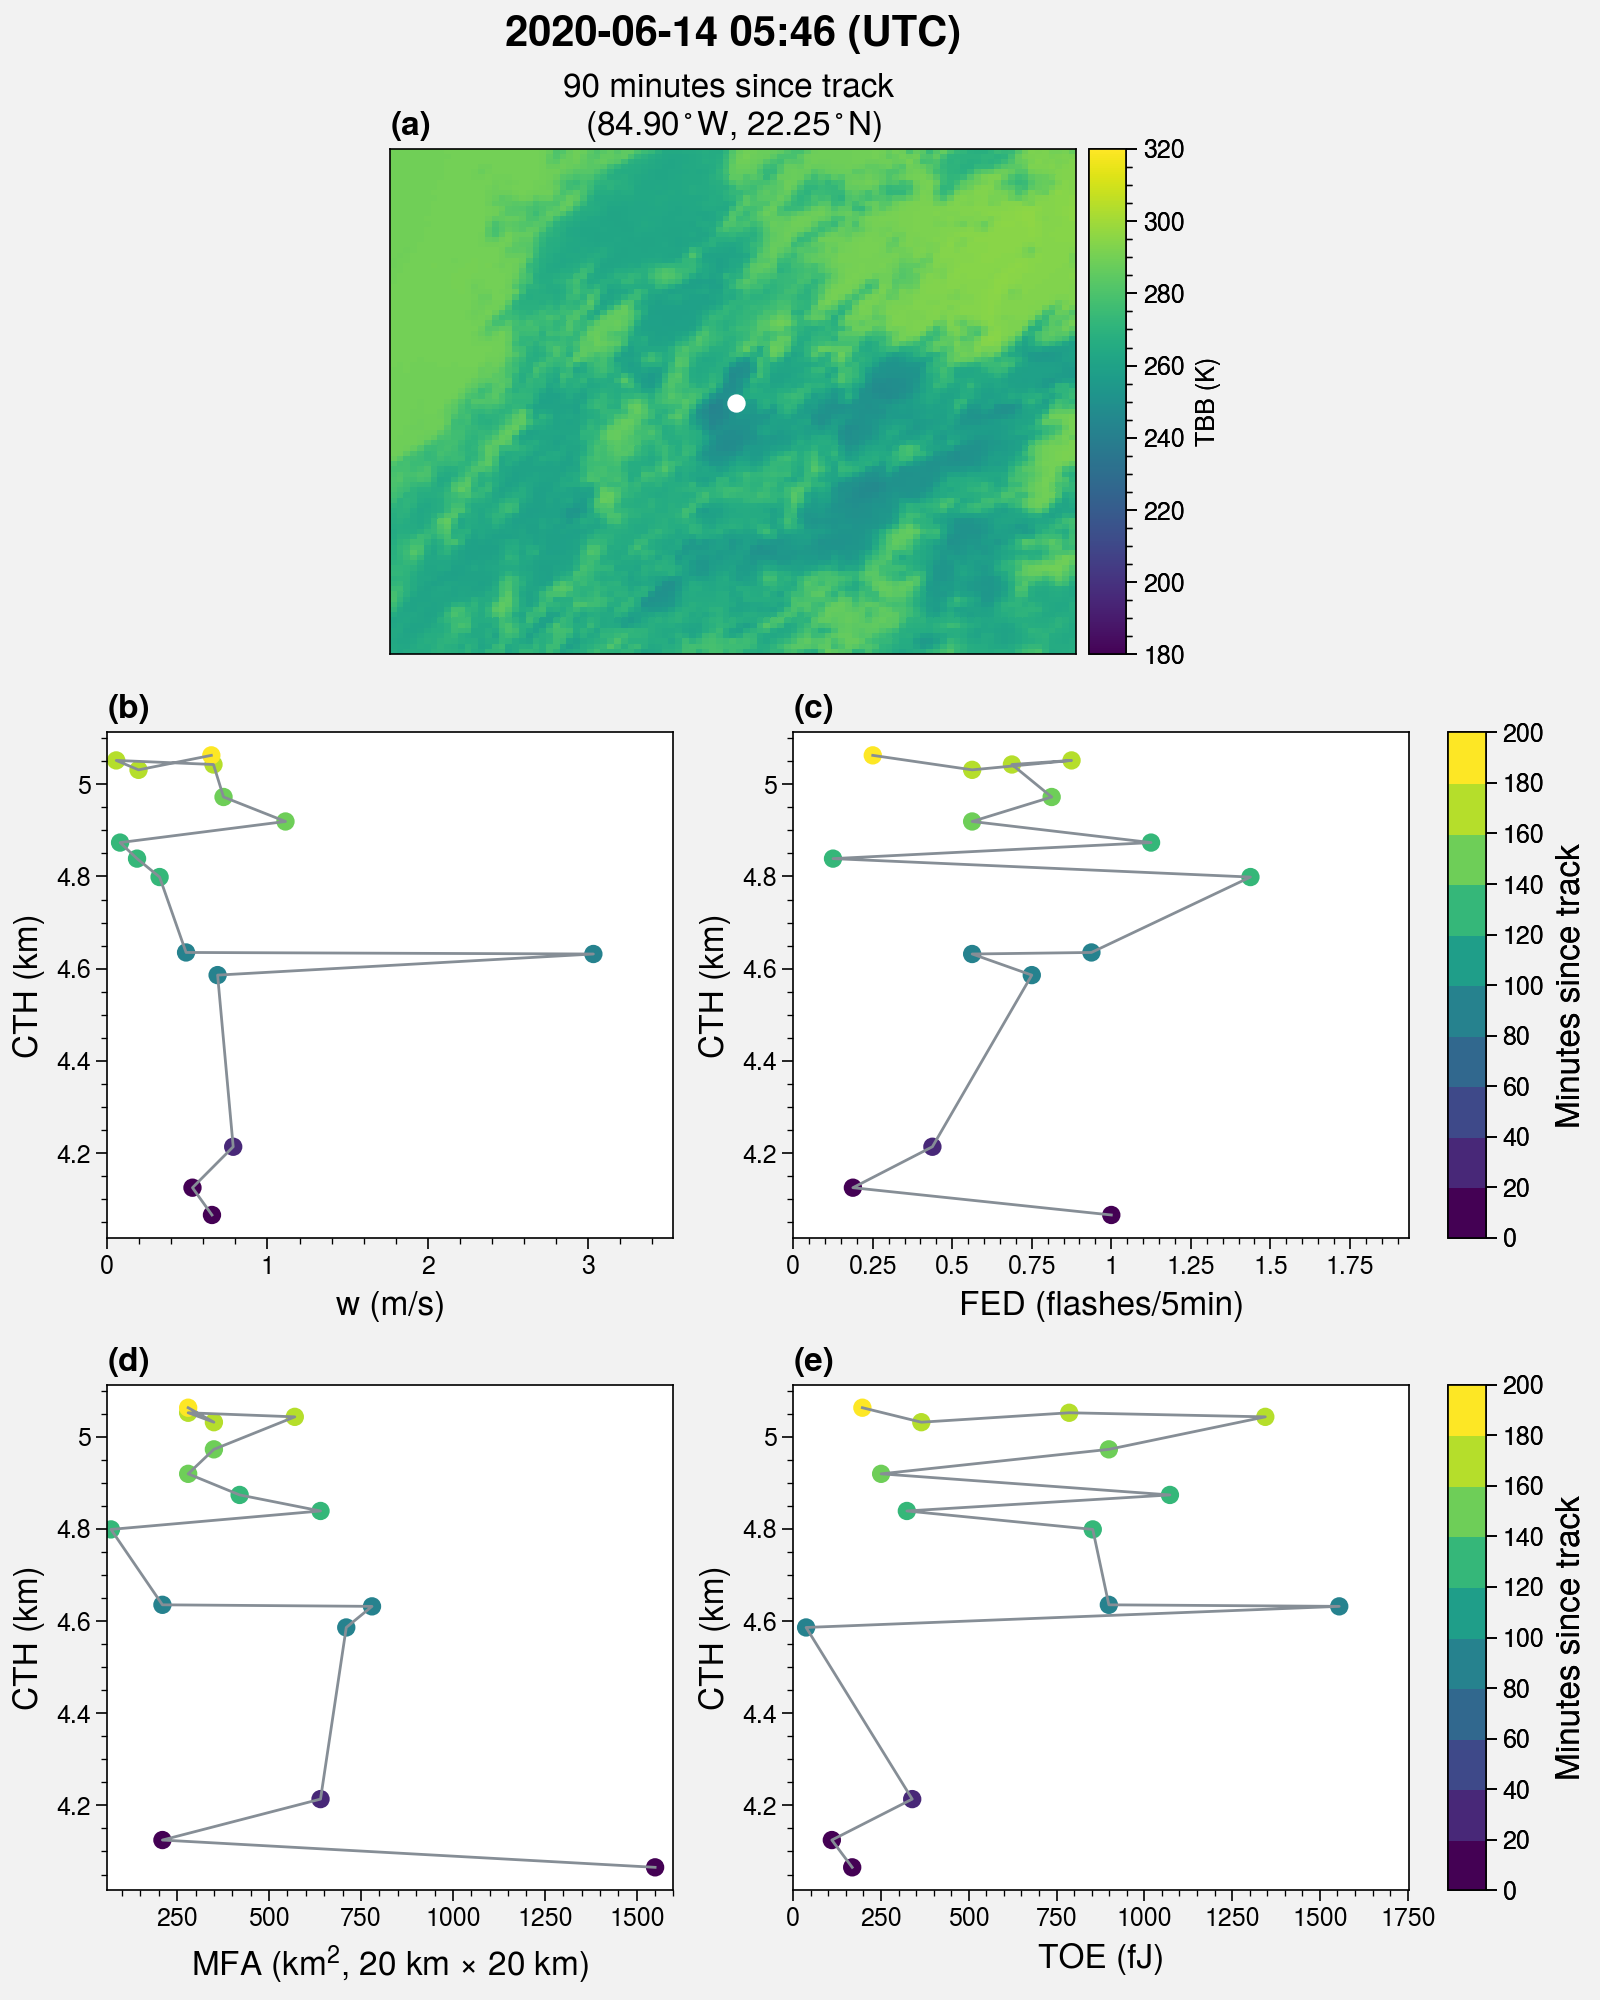

In [11]:
subplot_array = [[0, 1, 1, 0],
                 [2, 2, 3, 3],
                 [4, 4, 5, 5],
                ]

fig, axs = plot.subplots(subplot_array, share=0, figsize=(8, 10))#axwidth=4,)

cell = 1168000
plot_case(axs[1:], cell=cell)
savename = plot_tbb(axs[0], cell=cell, index=4)
axs.format(abc=True, abcstyle='(a)', abcsize=12)
fig.savefig(f'../figures/{savename}.png')

### Case 2

-2127518.062808443 -1910124.7106103757 1922262.4517984216 1714293.359682685


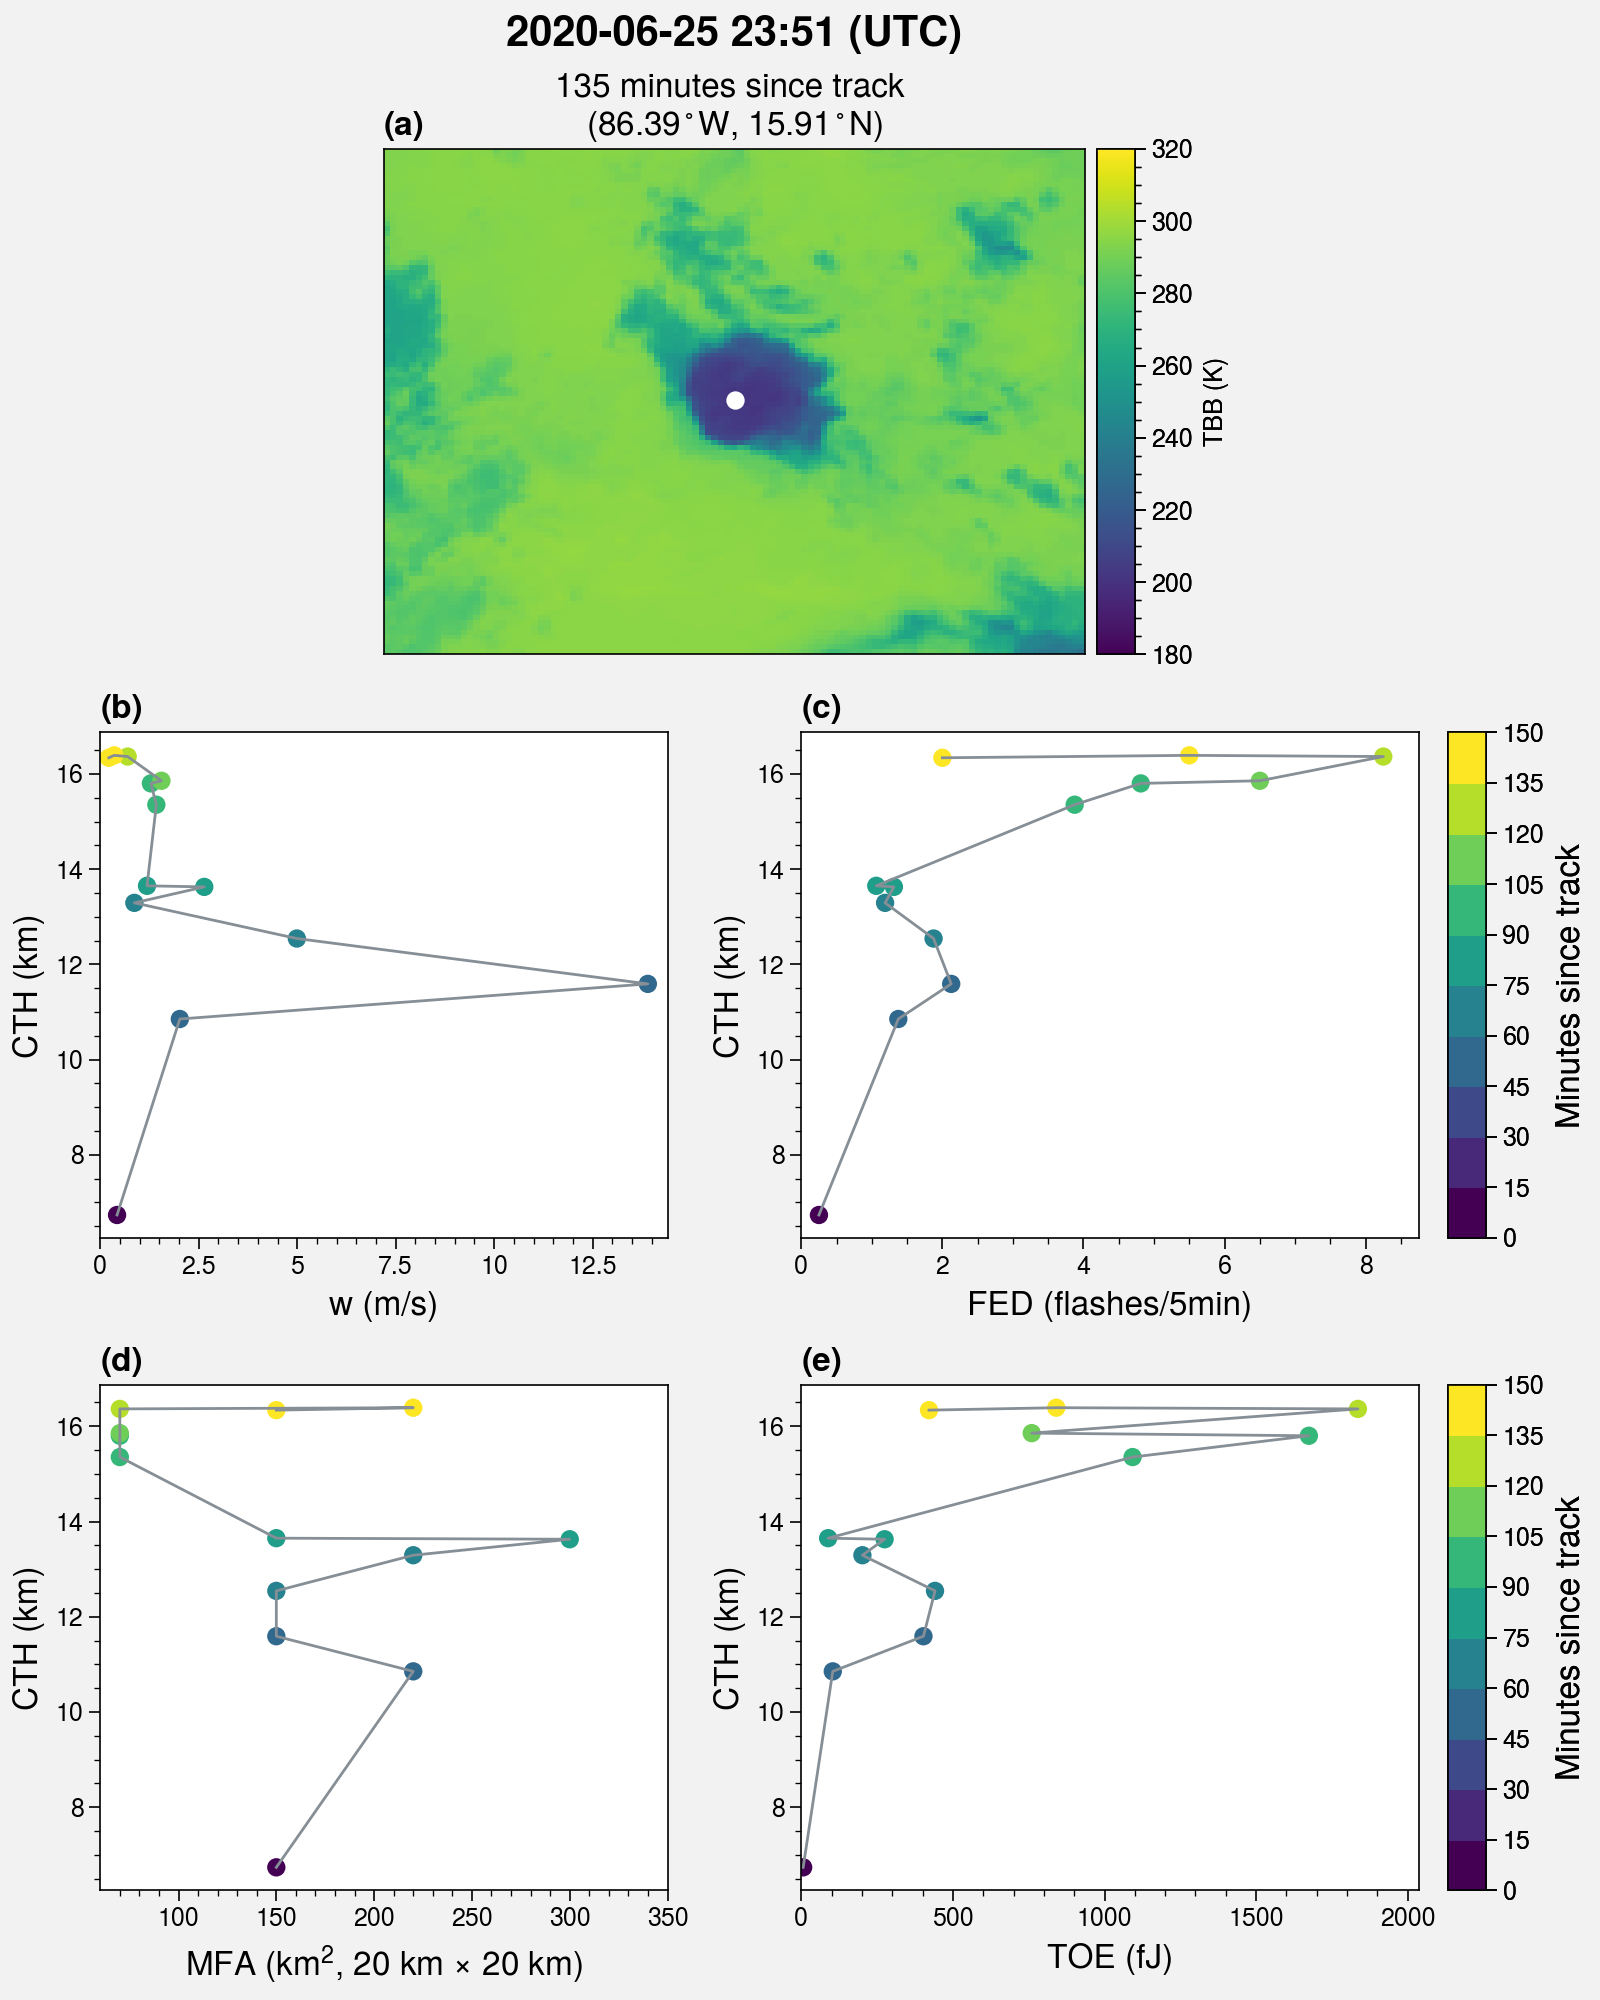

In [12]:
subplot_array = [[0, 1, 1, 0],
                 [2, 2, 3, 3],
                 [4, 4, 5, 5],
                ]

fig, axs = plot.subplots(subplot_array, share=0, figsize=(8, 10))

cell = 2146106
plot_case(axs[1:], cell=cell)
savename = plot_tbb(axs[0], cell=cell)
axs.format(abc=True, abcstyle='(a)', abcsize=12)
fig.savefig(f'../figures/{savename}.png')

In [13]:
# subplot_array = [[0, 1, 1, 0],
#                  [2, 2, 3, 3],
#                  [4, 4, 5, 5],
#                 ]

# fig, axs = plot.subplots(subplot_array, share=0, axwidth=4,)

# cell = 926334
# plot_case(axs[1:], cell=cell)
# savename = plot_tbb(axs[0], cell=cell)
# axs.format(abc=True, abcstyle='(a)', abcsize=12)
# fig.savefig(f'../figures/{savename}.png')